## CNN-Project-Exercise
We'll be using the CIFAR-10 dataset, which is very famous dataset for image recognition! 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

### Follow the Instructions in Bold, if you get stuck somewhere, view the solutions video! Most of the challenge with this project is actually dealing with the data and its dimensions, not from setting up the CNN itself!

## Step 0: Get the Data

** *Note: If you have trouble with this just watch the solutions video. This doesn't really have anything to do with the exercise, its more about setting up your data. Please make sure to watch the solutions video before posting any QA questions.* **

** Download the data for CIFAR from here: https://www.cs.toronto.edu/~kriz/cifar.html **

**Specifically the CIFAR-10 python version link: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz **

** Remember the directory you save the file in! **

In [1]:
# Put file path as a string here
CIFAR_DIR = '../TensorFlow-Bootcamp/03-Convolutional-Neural-Networks/cifar-10-batches-py/'

The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle. 

** Load the Data. Use the Code Below to load the data: **

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta', 
        'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 
        'test_batch']

In [4]:
all_data = [0, 1, 2, 3, 4, 5, 6]

In [5]:
for i, direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [6]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [7]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

** Why the 'b's in front of the string? **
Bytes literals are always prefixed with 'b' or 'B'; they produce an instance of the bytes type instead of the str type. They may only contain ASCII characters; bytes with a numeric value of 128 or greater must be expressed with escapes.

https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal

In [8]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

Loaded in this way, each of the batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Display a single image using matplotlib.

** Grab a single image from data_batch1 and display it with plt.imshow(). You'll need to reshape and transpose the numpy array inside the X = data_batch[b'data'] dictionary entry.**

** It should end up looking like this: **

    # Array of all images reshaped and formatted for viewing
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [11]:
X = data_batch1[b'data']

In [13]:
# 32*32*3
X.shape

(10000, 3072)

In [14]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [15]:
X[0].shape

(32, 32, 3)

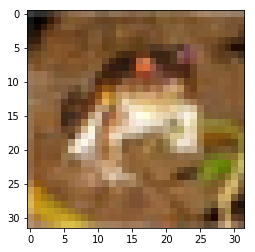

In [16]:
plt.imshow(X[0])

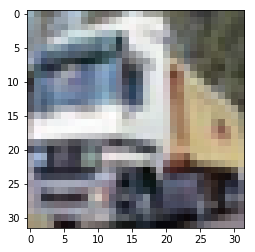

In [17]:
plt.imshow(X[1])

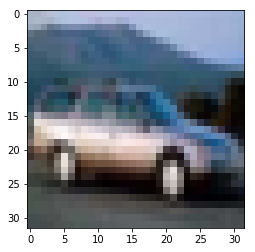

In [19]:
plt.imshow(X[4])

In [21]:
X = data_batch1[b'data']

In [23]:
all_images = X.reshape(10000, 3, 32, 32)

In [24]:
sample = all_images[0]

In [26]:
sample.shape

(3, 32, 32)

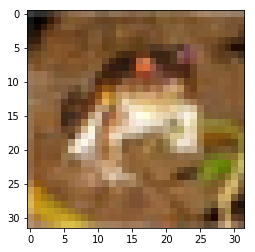

In [28]:
plt.imshow(sample.transpose(1, 2, 0))

# Helper Functions for Dealing With Data.

** Use the provided code below to help with dealing with grabbing the next batch once you've gotten ready to create the Graph Session. Can you break down how it works? **

In [29]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [30]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

** How to use the above code: **

In [31]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating the Model

** Import tensorflow **

In [32]:
import tensorflow as tf

** Create 2 placeholders, x and y_true. Their shapes should be: **

* x shape = [None,32,32,3]
* y_true shape = [None,10]


In [33]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

** Create one more placeholder called hold_prob. No need for shape here. This placeholder will just hold a single probability for the dropout. **

In [34]:
hold_prob = tf.placeholder(tf.float32)

### Helper Functions

** Grab the helper functions from MNIST with CNN (or recreate them here yourself for a hard challenge!). You'll need: **

* init_weights
* init_bias
* conv2d
* max_pool_2by2
* convolutional_layer
* normal_full_layer

In [35]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input_x, shape):
    w = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, w) + b)

def dense_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    w = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, w) + b

### Create the Layers

** Create a convolutional layer and a pooling layer as we did for MNIST. **
** Its up to you what the 2d size of the convolution should be, but the last two digits need to be 3 and 32 because of the 3 color channels and 32 pixels. So for example you could use:**

        convo_1 = convolutional_layer(x,shape=[4,4,3,32])

In [36]:
conv1 = conv_layer(x, shape=[4, 4, 3, 32])
conv1_pooling = max_pool_2x2(conv1)

** Create the next convolutional and pooling layers.  The last two dimensions of the convo_2 layer should be 32,64 **

In [37]:
conv2 = conv_layer(conv1_pooling, shape=[4, 4, 32, 64])
conv2_pooling = max_pool_2x2(conv2)

** Now create a flattened layer by reshaping the pooling layer into [-1,8 \* 8 \* 64] or [-1,4096] **

In [38]:
8*8*64

4096

In [39]:
conv2_flat = tf.reshape(conv2_pooling, [-1, 8*8*64])

** Create a new full layer using the normal_full_layer function and passing in your flattend convolutional 2 layer with size=1024. (You could also choose to reduce this to something like 512)**

In [40]:
dense1 = tf.nn.relu(dense_layer(conv2_flat, 1024))

** Now create the dropout layer with tf.nn.dropout, remember to pass in your hold_prob placeholder. **

In [41]:
dense1_dropout = tf.nn.dropout(dense1, keep_prob=hold_prob)

** Finally set the output to y_pred by passing in the dropout layer into the normal_full_layer function. The size should be 10 because of the 10 possible labels**

In [42]:
y_pred = dense_layer(dense1_dropout, 10)

### Loss Function

** Create a cross_entropy loss function **

In [43]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Optimizer
** Create the optimizer using an Adam Optimizer. **

In [46]:
optimizer = tf.train.AdamOptimizer(learning_rate=.001)
train = optimizer.minimize(cross_entropy)

** Create a variable to intialize all the global tf variables. **

In [47]:
init = tf.global_variables_initializer()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [48]:
with tf.Session() as s:
    s.run(init)
    
    for i in range(1000):
        batch = ch.next_batch(100)
        s.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob:.5})
        
        if i % 100 == 0:
            print("Step: {}".format(i))
            print("Accuracy: ")
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            print(s.run(
                acc, feed_dict={x: ch.test_images, y_true: ch.test_labels, hold_prob: 1.0}))

Step: 0
Accuracy: 
0.103
Step: 100
Accuracy: 
0.3979
Step: 200
Accuracy: 
0.4549
Step: 300
Accuracy: 
0.492
Step: 400
Accuracy: 
0.4972
Step: 500
Accuracy: 
0.5337
Step: 600
Accuracy: 
0.564
Step: 700
Accuracy: 
0.569
Step: 800
Accuracy: 
0.5913
Step: 900
Accuracy: 
0.5855
